In [1]:
import time
from src.databases.pgvector_database import PgVectorDatabase
from src.datasets.service.openai_small_dataset import OpenAISmallDataset
from src.file_downloader.file_download_impl import FileDownloaderImpl
from src.datasets.utils import tqdm_with_dataset

def recall(ground_truth_neighbors, predicted_neighbors):
    return len(set(ground_truth_neighbors).intersection(set(predicted_neighbors))) / len(ground_truth_neighbors)

pgvector = PgVectorDatabase()
pgvector.start(reset=True)

DockerException: The command executed was `C:\Program Files\Docker\Docker\resources\bin\docker.EXE compose --file docker/pgvector\docker-compose.yaml --env-file docker/pgvector\config.env --project-name vector-test-pgvector down`.
It returned with code 1
The content of stdout can be found above the stacktrace (it wasn't captured).
The content of stderr can be found above the stacktrace (it wasn't captured).

In [4]:
file_downloader = FileDownloaderImpl()
dataset = OpenAISmallDataset(file_downloader)

In [3]:
pgvector.create_table(dataset.get_vector_size())

In [6]:
for documents in tqdm_with_dataset(dataset, 'train'):
    pgvector.insert_batch(documents)

100%|██████████| 50000/50000 [03:17<00:00, 253.02it/s]


In [8]:
def test():
    scores = {}

    for k in [1, 5]:
        scores[k] = 0
        print(f"Recall@{k}")
        for documents in tqdm_with_dataset(dataset, 'test', batch_size=10):
            for document in documents:
                predicted_neighbors = pgvector.get_neighbors(document, k)
                scores[k] += recall(document.neighbors[:k], predicted_neighbors)
        scores[k] /= dataset.get_length_of_test()
    return scores

In [17]:
# 인덱스가 없을때 KNN 기반의 정확 검색을 테스트하고, 대략적인 속도와 Recall 수치(=1)을 확인
test_result1 = test()
test_result1

Recall@1


100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]


Recall@5


100%|██████████| 1000/1000 [03:47<00:00,  4.39it/s]


{1: 1.0, 5: 1.0}

In [20]:
# 인덱스 생성 요청
from src.databases.indexes.hnsw_index import HNSWIndex
from src.databases.indexes.distance import Distance
pgvector.create_index(HNSWIndex(distance_metric=Distance.COSINE))

In [21]:
# ef_search 값은 HNSW 알고리즘이 벡터를 탐색할 때 최종 레이어에서 몇개의 후보를 확인 예정인지를 의미합니다.
# 만약 이 값이 K보다 작은 경우, 반환할 수 있는 노드 수 자체가 부족하기 때문에 Recall은 급격하게 감소할 것으로 예상합니다.
# 이 값이 커질수록 더 많은 노드를 확인 후 정렬된 순서를 반환하기 때문에 Recall 수치가 증가해야합니다.
# 인덱스가 잘 구성되어있다는 가정 하에 어느 선 이상부터는 Recall 수치의 변화가 적을 것으로 예상합니다.
result = {}
for ef_search in [3, 5, 10, 20, 30, 40, 50]:
    pgvector.set_ef_search(ef_search)
    scores = test()
    result[ef_search] = scores
    print(ef_search, scores)

Recall@1


100%|██████████| 1000/1000 [00:46<00:00, 21.59it/s]


Recall@5


100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


3 {1: 0.722, 5: 0.4952000000000054}
Recall@1


100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]


Recall@5


100%|██████████| 1000/1000 [00:45<00:00, 21.97it/s]


5 {1: 0.824, 5: 0.7867999999999986}
Recall@1


100%|██████████| 1000/1000 [00:45<00:00, 21.86it/s]


Recall@5


100%|██████████| 1000/1000 [00:47<00:00, 21.14it/s]


10 {1: 0.92, 5: 0.8905999999999976}
Recall@1


100%|██████████| 1000/1000 [00:48<00:00, 20.78it/s]


Recall@5


100%|██████████| 1000/1000 [00:46<00:00, 21.33it/s]


20 {1: 0.967, 5: 0.9447999999999988}
Recall@1


100%|██████████| 1000/1000 [00:46<00:00, 21.30it/s]


Recall@5


100%|██████████| 1000/1000 [00:47<00:00, 21.15it/s]


30 {1: 0.986, 5: 0.9699999999999989}
Recall@1


100%|██████████| 1000/1000 [00:48<00:00, 20.71it/s]


Recall@5


100%|██████████| 1000/1000 [00:48<00:00, 20.55it/s]


40 {1: 0.99, 5: 0.9787999999999987}
Recall@1


100%|██████████| 1000/1000 [00:53<00:00, 18.74it/s]


Recall@5


100%|██████████| 1000/1000 [00:50<00:00, 19.90it/s]

50 {1: 0.992, 5: 0.9859999999999989}


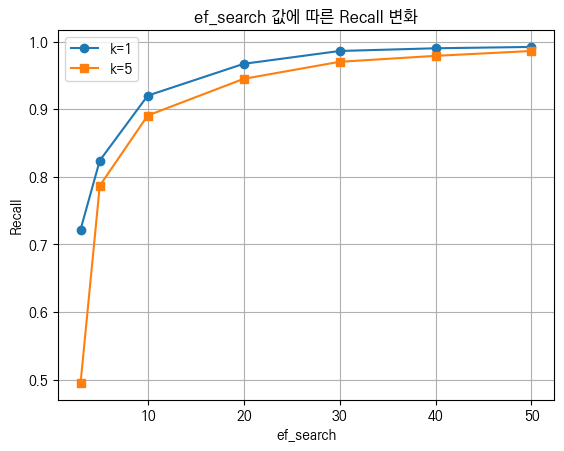

In [30]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')

ef_search = list(result.keys())
k1 = [result[k][1] for k in ef_search]
k5 = [result[k][5] for k in ef_search]

plt.plot(ef_search, k1, marker='o', label='k=1')
plt.plot(ef_search, k5, marker='s', label='k=5')

plt.xlabel('ef_search')
plt.ylabel('Recall')
plt.title('ef_search 값에 따른 Recall 변화')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ef_construction must be greater than or equal to 2 * m
from src.databases.indexes.hnsw_index import HNSWIndex
from src.databases.indexes.distance import Distance
import time

test_ef_construction_result = {}
test_ef_construction_build_time = {}
for ef_construction in [32, 64, 128, 256, 512]:
    # 기존 인덱스 제거
    pgvector.drop_index()

    # 인덱스 생성 및 소요 시간 측정
    start_time = time.perf_counter()
    pgvector.create_index(HNSWIndex(distance_metric=Distance.COSINE, ef_construction=ef_construction))
    build_time = time.perf_counter() - start_time
    test_ef_construction_build_time[ef_construction] = build_time

    # 검색 수행
    pgvector.set_ef_search(10)
    scores = test()
    test_ef_construction_result[ef_construction] = scores

    print(ef_construction, build_time, scores)


In [16]:
test_ef_construction_build_time = {32: 120.50677790003829,
 64: 167.75247049995232,
 128: 245.75969559990335,
 256: 394.287854299997,
 512: 758.1686733000679}

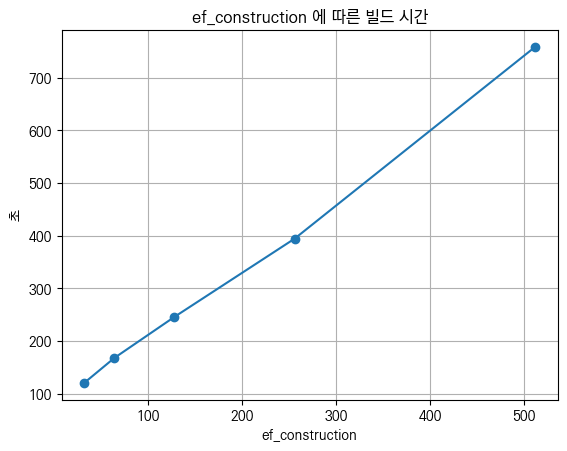

In [17]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')

ef_search = list(test_ef_construction_build_time.keys())

plt.plot(
    test_ef_construction_build_time.keys(),
    test_ef_construction_build_time.values(), marker='o')

plt.xlabel('ef_construction')
plt.ylabel('초')
plt.title('ef_construction 에 따른 빌드 시간')
plt.grid(True)
plt.show()

In [23]:
test_ef_construction_result = {32: {1: 0.903, 5: 0.8757999999999986},
 64: {1: 0.92, 5: 0.8893999999999984},
 128: {1: 0.913, 5: 0.8963999999999982},
 256: {1: 0.921, 5: 0.8889999999999982},
 512: {1: 0.915, 5: 0.8891999999999981}}

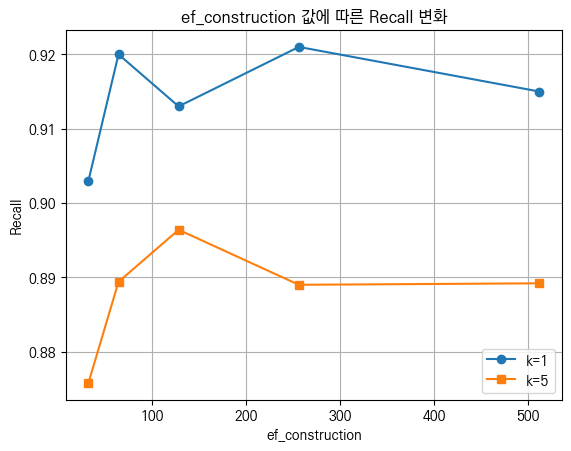

In [24]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')

ef_construction = list(test_ef_construction_result.keys())
k1 = [test_ef_construction_result[k][1] for k in test_ef_construction_result]
k5 = [test_ef_construction_result[k][5] for k in test_ef_construction_result]

plt.plot(ef_construction, k1, marker='o', label='k=1')
plt.plot(ef_construction, k5, marker='s', label='k=5')

plt.xlabel('ef_construction')
plt.ylabel('Recall')
plt.title('ef_construction 값에 따른 Recall 변화')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
from src.databases.indexes.hnsw_index import HNSWIndex
from src.databases.indexes.distance import Distance

test_ef_construction_and_ef_search = {

}
for ef_construction in [32, 64, 128, 256, 512]:
    # 기존 인덱스 제거
    pgvector.drop_index()

    # 인덱스 생성
    pgvector.create_index(HNSWIndex(distance_metric=Distance.COSINE, ef_construction=ef_construction))

    test_ef_construction_and_ef_search[ef_construction] = {}
    for ef_search in [3, 5, 10, 20, 30, 40, 50]:
        # 검색 수행
        pgvector.set_ef_search(ef_search)

        score = 0
        for documents in tqdm_with_dataset(dataset, 'test', batch_size=10):
            for document in documents:
                predicted_neighbors = pgvector.get_neighbors(document, 5)
                score += recall(document.neighbors[:5], predicted_neighbors)
        score /= dataset.get_length_of_test()

        test_ef_construction_and_ef_search[ef_construction][ef_search] = score


100%|██████████| 1000/1000 [00:49<00:00, 20.04it/s]


In [8]:
test_ef_construction_and_ef_search = {32: {3: 0.48720000000000524,
  5: 0.7785999999999986,
  10: 0.8733999999999983,
  20: 0.9331999999999985,
  30: 0.959999999999998,
  40: 0.9715999999999986,
  50: 0.9801999999999988},
 64: {3: 0.49680000000000574,
  5: 0.7937999999999986,
  10: 0.8937999999999979,
  20: 0.9475999999999986,
  30: 0.9687999999999987,
  40: 0.9789999999999989,
  50: 0.9859999999999991},
 128: {3: 0.49240000000000544,
  5: 0.7973999999999987,
  10: 0.894999999999998,
  20: 0.9549999999999985,
  30: 0.9727999999999987,
  40: 0.9827999999999987,
  50: 0.9875999999999991},
 256: {3: 0.4952000000000053,
  5: 0.7891999999999995,
  10: 0.8939999999999986,
  20: 0.951799999999999,
  30: 0.9717999999999989,
  40: 0.981599999999999,
  50: 0.9867999999999993},
 512: {3: 0.48780000000000495,
  5: 0.7753999999999988,
  10: 0.890199999999998,
  20: 0.9495999999999988,
  30: 0.9709999999999988,
  40: 0.979999999999999,
  50: 0.9865999999999994}}

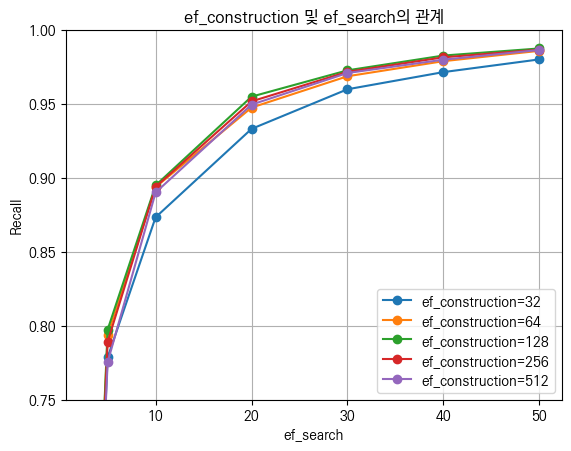

In [9]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')


ef_constructions = list(test_ef_construction_and_ef_search.keys())
for ef_construction in ef_constructions:
    x = test_ef_construction_and_ef_search[ef_construction].keys()
    y = [test_ef_construction_and_ef_search[ef_construction][ef_search] for ef_search in x]
    plt.plot(x, y, marker='o', label=f'ef_construction={ef_construction}')

plt.xlabel('ef_search')
plt.ylabel('Recall')
plt.title('ef_construction 및 ef_search의 관계')
plt.ylim(0.75, 1.00)
plt.legend()
plt.grid(True)
plt.show()

In [11]:
from src.databases.indexes.hnsw_index import HNSWIndex
from src.databases.indexes.distance import Distance

test_m_and_ef_search = {}
test_m_build_time = {}
# DETAIL:  Valid values are between "2" and "100".
for m in [2, 4, 8, 16, 32, 64]:
    # 기존 인덱스 제거
    pgvector.drop_index()

    # 인덱스 생성
    start_time = time.perf_counter()
    pgvector.create_index(HNSWIndex(distance_metric=Distance.COSINE, m=m, ef_construction=256))
    build_time = time.perf_counter() - start_time
    test_m_build_time[m] = build_time

    test_m_and_ef_search[m] = {}
    for ef_search in [3, 5, 10, 20, 30, 40, 50]:
        # 검색 수행
        pgvector.set_ef_search(ef_search)

        score = 0
        for documents in tqdm_with_dataset(dataset, 'test', batch_size=10):
            for document in documents:
                predicted_neighbors = pgvector.get_neighbors(document, 5)
                score += recall(document.neighbors[:5], predicted_neighbors)
        score /= dataset.get_length_of_test()

        test_m_and_ef_search[m][ef_search] = score


100%|██████████| 1000/1000 [00:50<00:00, 19.99it/s]


InvalidParameterValue: value 128 out of bounds for option "m"
DETAIL:  Valid values are between "2" and "100".


In [15]:
test_m_and_ef_search = {2: {3: 0.05980000000000009,
  5: 0.1184000000000001,
  10: 0.22019999999999976,
  20: 0.35220000000000007,
  30: 0.4444000000000003,
  40: 0.5000000000000007,
  50: 0.5444000000000006},
 4: {3: 0.2143999999999989,
  5: 0.40000000000000047,
  10: 0.5710000000000005,
  20: 0.7279999999999994,
  30: 0.801199999999999,
  40: 0.8425999999999984,
  50: 0.8671999999999981},
 8: {3: 0.39980000000000165,
  5: 0.6271999999999998,
  10: 0.7857999999999995,
  20: 0.8797999999999991,
  30: 0.9247999999999992,
  40: 0.9483999999999985,
  50: 0.9599999999999991},
 16: {3: 0.5014000000000051,
  5: 0.8007999999999993,
  10: 0.8947999999999983,
  20: 0.9521999999999992,
  30: 0.972599999999999,
  40: 0.9807999999999991,
  50: 0.9873999999999992},
 32: {3: 0.5656000000000091,
  5: 0.8979999999999989,
  10: 0.9521999999999988,
  20: 0.980599999999999,
  30: 0.9897999999999992,
  40: 0.9931999999999994,
  50: 0.9945999999999995},
 64: {3: 0.5816000000000099,
  5: 0.9437999999999986,
  10: 0.9801999999999988,
  20: 0.9937999999999994,
  30: 0.9969999999999997,
  40: 0.9979999999999998,
  50: 0.9985999999999999}}

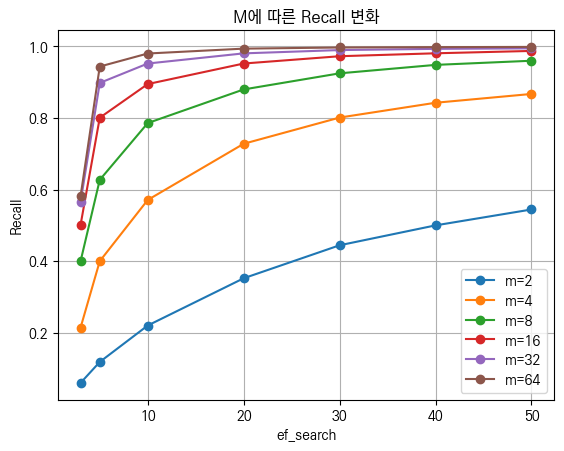

In [12]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')

m_list = list(test_m_and_ef_search.keys())
for m in m_list:
    x = test_m_and_ef_search[m].keys()
    y = [test_m_and_ef_search[m][ef_search] for ef_search in x]
    plt.plot(x, y, marker='o', label=f'm={m}')

plt.xlabel('ef_search')
plt.ylabel('Recall')
plt.title('M에 따른 Recall 변화')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
test_m_build_time = {2: 57.122860400006175,
 4: 104.55957230005879,
 8: 189.18652310001198,
 16: 372.44035030005034,
 32: 785.5718132999027,
 64: 2110.0874598000664}

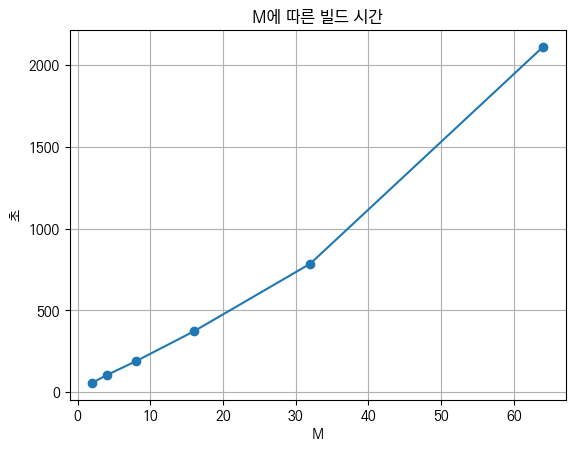

In [13]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')

plt.plot(
    test_m_build_time.keys(),
    test_m_build_time.values(), marker='o')

plt.xlabel('M')
plt.ylabel('초')
plt.title('M에 따른 빌드 시간')
plt.grid(True)
plt.show()

In [4]:
test_m_and_ef_construction

{2: {}}

In [5]:
from src.databases.indexes.hnsw_index import HNSWIndex
from src.databases.indexes.distance import Distance

test_m_and_ef_construction = {}
for m in [2, 4, 8, 16, 32, 64]:
    test_m_and_ef_construction[m] = {}
    for ef_construction in [128, 256, 512]:
        print(m, ef_construction)
        # 기존 인덱스 제거
        pgvector.drop_index()

        # 인덱스 생성
        pgvector.create_index(
            HNSWIndex(distance_metric=Distance.COSINE, m=m, ef_construction=ef_construction)
        )

        # 검색 수행
        pgvector.set_ef_search(20)

        score = 0
        for documents in tqdm_with_dataset(dataset, 'test', batch_size=10):
            for document in documents:
                predicted_neighbors = pgvector.get_neighbors(document, 5)
                score += recall(document.neighbors[:5], predicted_neighbors)
        score /= dataset.get_length_of_test()

        test_m_and_ef_construction[m][ef_construction] = score


2 128


100%|██████████| 1000/1000 [00:45<00:00, 21.77it/s]


2 256


100%|██████████| 1000/1000 [00:46<00:00, 21.48it/s]


2 512


100%|██████████| 1000/1000 [00:46<00:00, 21.66it/s]


4 128


100%|██████████| 1000/1000 [00:48<00:00, 20.62it/s]


4 256


100%|██████████| 1000/1000 [00:48<00:00, 20.62it/s]


4 512


100%|██████████| 1000/1000 [00:47<00:00, 21.12it/s]


8 128


100%|██████████| 1000/1000 [00:48<00:00, 20.78it/s]


8 256


100%|██████████| 1000/1000 [00:48<00:00, 20.83it/s]


8 512


100%|██████████| 1000/1000 [00:47<00:00, 20.88it/s]


16 128


100%|██████████| 1000/1000 [00:48<00:00, 20.51it/s]


16 256


100%|██████████| 1000/1000 [00:49<00:00, 20.39it/s]


16 512


100%|██████████| 1000/1000 [00:49<00:00, 20.37it/s]


32 128


100%|██████████| 1000/1000 [00:50<00:00, 19.80it/s]


32 256


100%|██████████| 1000/1000 [00:50<00:00, 19.80it/s]


32 512


100%|██████████| 1000/1000 [00:51<00:00, 19.35it/s]


64 128


100%|██████████| 1000/1000 [00:52<00:00, 19.06it/s]


64 256


100%|██████████| 1000/1000 [00:53<00:00, 18.83it/s]


64 512


100%|██████████| 1000/1000 [00:52<00:00, 19.13it/s]


In [7]:
test_m_and_ef_construction = {2: {128: 0.33419999999999994,
  256: 0.3516000000000001,
  512: 0.3494000000000004},
 4: {128: 0.7205999999999992,
  256: 0.7247999999999993,
  512: 0.7377999999999987},
 8: {128: 0.8773999999999986,
  256: 0.8843999999999992,
  512: 0.8811999999999991},
 16: {128: 0.9521999999999992,
  256: 0.950199999999999,
  512: 0.9501999999999988},
 32: {128: 0.9783999999999987,
  256: 0.9821999999999991,
  512: 0.9801999999999992},
 64: {128: 0.9929999999999992,
  256: 0.9939999999999994,
  512: 0.9943999999999993}}

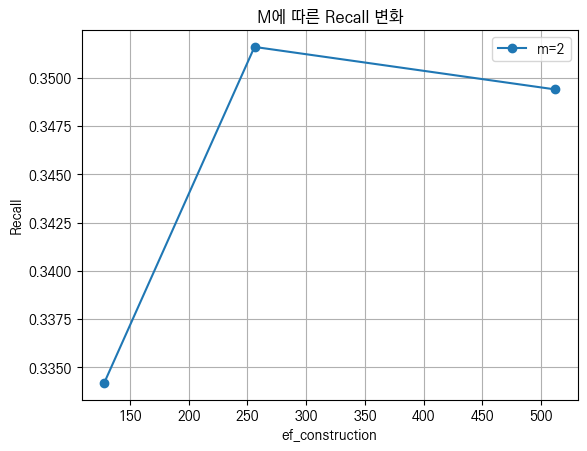

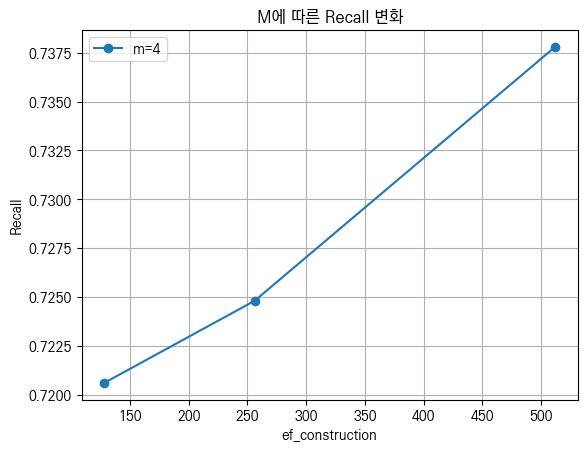

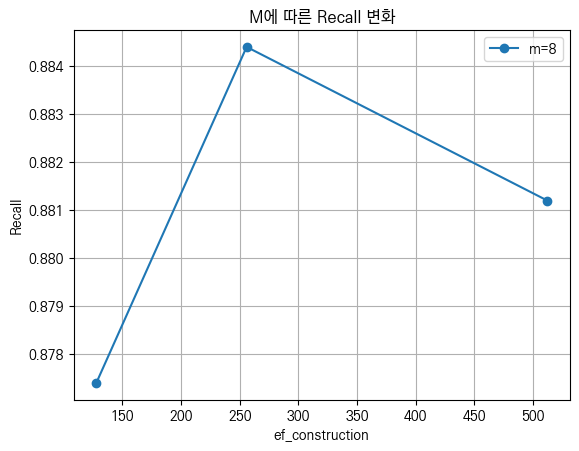

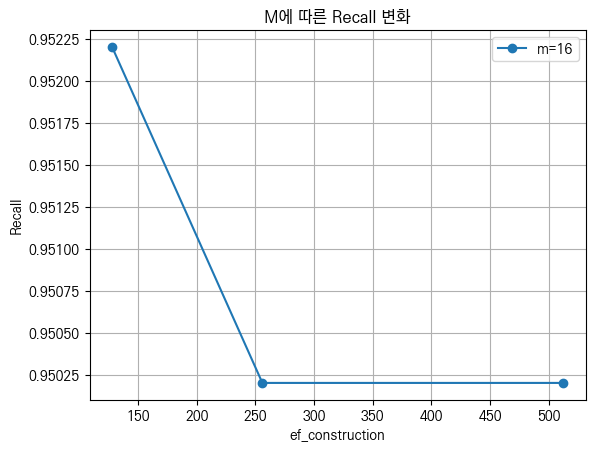

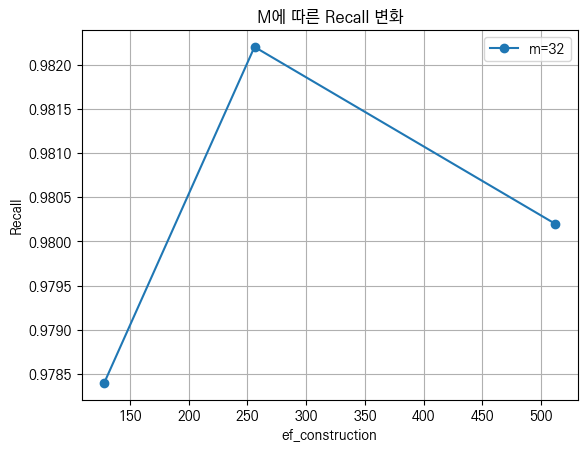

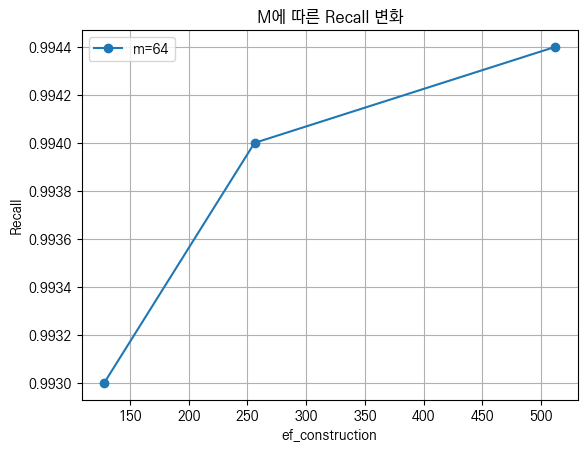

In [24]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')

m_list = list(test_m_and_ef_construction.keys())
for m in m_list:
    x = test_m_and_ef_construction[m].keys()
    y = [test_m_and_ef_construction[m][ef_search] for ef_search in x]
    plt.plot(x, y, marker='o', label=f'm={m}')

    plt.xlabel('ef_construction')
    plt.ylabel('Recall')
    plt.title('M에 따른 Recall 변화')
    plt.legend()
    plt.grid(True)
    plt.show()

[2, 4, 8, 16, 32, 64]
[2, 4, 8, 16, 32, 64]
[2, 4, 8, 16, 32, 64]


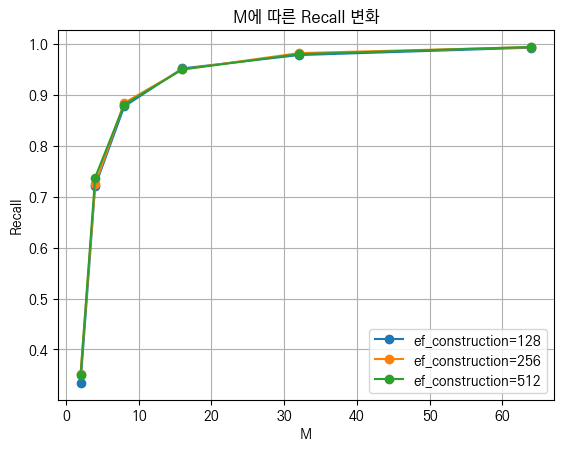

In [25]:
import matplotlib.pyplot as plt
plt.rc('font', family='KoPubDotum Medium')

m_list = list(test_m_and_ef_construction.keys())
for ef_construction in [128, 256, 512]:
    x = list(test_m_and_ef_construction.keys())
    print(x)
    y = [test_m_and_ef_construction[m][ef_construction] for m in x]
    plt.plot(x, y, marker='o', label=f'ef_construction={ef_construction}')

plt.xlabel('M')
plt.ylabel('Recall')
plt.title('M에 따른 Recall 변화')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
import pandas as pd
import numpy as np
df = pd.DataFrame.from_dict(test_m_and_ef_construction, orient='index')
df.index.name = "m"
df.columns.name = "ef_construction"

colors = pd.DataFrame('', index=df.index, columns=df.columns)

for col in df.columns[1:]:
    col_pos = df.columns.get_loc(col)
    left_col = df.columns[col_pos - 1]
    comp = df.loc[:, col] > df.loc[:, left_col]
    colors.loc[:, col] = np.where(comp, 'background-color: #d4edda;', 'background-color: #f8d7da;')

df.style.format("{:.3f}").apply(lambda _: colors, axis=None)

ef_construction,128,256,512
m,,,
2,0.334,0.352,0.349
4,0.721,0.725,0.738
8,0.877,0.884,0.881
16,0.952,0.950,0.950
32,0.978,0.982,0.980
64,0.993,0.994,0.994


In [26]:
from src.databases.indexes.hnsw_index import HNSWIndex
from src.databases.indexes.distance import Distance

test_m_and_ef_construction2 = {}
for m in [2, 4, 8, 16, 32, 64]:
    test_m_and_ef_construction2[m] = {}
    for ef_construction in [128, 256, 512]:
        print(m, ef_construction)
        # 기존 인덱스 제거
        pgvector.drop_index()

        # 인덱스 생성
        pgvector.create_index(
            HNSWIndex(distance_metric=Distance.COSINE, m=m, ef_construction=ef_construction)
        )

        # 검색 수행
        pgvector.set_ef_search(40)

        score = 0
        for documents in tqdm_with_dataset(dataset, 'test', batch_size=10):
            for document in documents:
                predicted_neighbors = pgvector.get_neighbors(document, 5)
                score += recall(document.neighbors[:5], predicted_neighbors)
        score /= dataset.get_length_of_test()

        test_m_and_ef_construction2[m][ef_construction] = score


2 128


100%|██████████| 1000/1000 [00:46<00:00, 21.51it/s]


2 256


100%|██████████| 1000/1000 [00:46<00:00, 21.57it/s]


2 512


100%|██████████| 1000/1000 [00:47<00:00, 21.21it/s]


4 128


100%|██████████| 1000/1000 [00:46<00:00, 21.63it/s]


4 256


100%|██████████| 1000/1000 [00:48<00:00, 20.65it/s]


4 512


100%|██████████| 1000/1000 [00:47<00:00, 20.95it/s]


8 128


100%|██████████| 1000/1000 [00:48<00:00, 20.72it/s]


8 256


100%|██████████| 1000/1000 [00:49<00:00, 20.26it/s]


8 512


100%|██████████| 1000/1000 [00:48<00:00, 20.57it/s]


16 128


100%|██████████| 1000/1000 [00:50<00:00, 19.78it/s]


16 256


100%|██████████| 1000/1000 [00:51<00:00, 19.48it/s]


16 512


100%|██████████| 1000/1000 [00:51<00:00, 19.30it/s]


32 128


100%|██████████| 1000/1000 [00:49<00:00, 20.04it/s]


32 256


100%|██████████| 1000/1000 [00:51<00:00, 19.41it/s]


32 512


100%|██████████| 1000/1000 [00:51<00:00, 19.57it/s]


64 128


100%|██████████| 1000/1000 [00:52<00:00, 19.13it/s]


64 256


100%|██████████| 1000/1000 [00:54<00:00, 18.43it/s]


64 512


100%|██████████| 1000/1000 [00:55<00:00, 18.06it/s]


In [30]:
test_m_and_ef_construction2 = {2: {128: 0.49420000000000003,
  256: 0.5076000000000006,
  512: 0.5206000000000008},
 4: {128: 0.838799999999998, 256: 0.8429999999999985, 512: 0.8431999999999985},
 8: {128: 0.9403999999999983,
  256: 0.9477999999999986,
  512: 0.9465999999999988},
 16: {128: 0.9825999999999989,
  256: 0.980399999999999,
  512: 0.9797999999999989},
 32: {128: 0.9915999999999993,
  256: 0.9937999999999995,
  512: 0.9941999999999996},
 64: {128: 0.9969999999999997,
  256: 0.9977999999999997,
  512: 0.9977999999999997}}

In [27]:
import pandas as pd
import numpy as np

In [34]:
df = pd.DataFrame.from_dict(test_m_and_ef_construction2, orient='index')
df.index.name = "m"
df.columns.name = "ef_construction"

colors = pd.DataFrame('', index=df.index, columns=df.columns)

for col in df.columns[1:]:
    col_pos = df.columns.get_loc(col)
    left_col = df.columns[col_pos - 1]
    comp = df.loc[:, col] > df.loc[:, left_col]
    colors.loc[:, col] = np.where(comp, 'background-color: #d4edda;', 'background-color: #f8d7da;')

df.style.format("{:.3f}").apply(lambda _: colors, axis=None)

ef_construction,128,256,512
m,,,
2,0.494,0.508,0.521
4,0.839,0.843,0.843
8,0.940,0.948,0.947
16,0.983,0.980,0.980
32,0.992,0.994,0.994
64,0.997,0.998,0.998
